In [1]:
# Check if the code is running in a Colab environment
if 'google.colab' in str(get_ipython()):  # If the code is running in Colab
    # mount google drive
    from google.colab import drive
    drive.mount('/content/drive')

    # set the base path to a Google Drive folder
    base_path = '/content/drive/MyDrive/Colab Notebooks'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
!pip install polars
!pip install annoy
!pip install torch_geometric
!pip install torch

In [17]:
import polars as pl
import torch
from torch_geometric.data import Data
from annoy import AnnoyIndex
import numpy as np
from torch_geometric.nn import SAGEConv

# Load the dataset
train_df = pl.read_parquet('/content/drive/MyDrive/Colab Notebooks/OTTO Recommendation System./train.parquet', low_memory=True)
test = pl.read_parquet('/content/drive/MyDrive/Colab Notebooks/OTTO Recommendation System./test.parquet')

In [18]:
# Create lagged dataframe
def lagged_df(df):
    df = df.with_columns([
        pl.col("aid").shift(1).over("session").alias("prev_aid")
    ])
    # Drop rows where prev_aid is null (first item in a session)
    df = df.drop_nulls(subset=['prev_aid'])
    return df

train_df = lagged_df(train_df)
test= lagged_df(test)

In [19]:
import polars as pl

train_df = train_df.filter(pl.col('type') == 0)
train_df

session,aid,ts,type,prev_aid
i32,i32,i32,u8,i32
0,1563459,1659304904,0,1517085
0,1309446,1659367439,0,1563459
0,16246,1659367719,0,1309446
0,1781822,1659367871,0,16246
0,1152674,1659367885,0,1781822
…,…,…,…,…
12899774,1399483,1661723976,0,33035
12899775,1760714,1661723990,0,1743151
12899776,1737908,1661723987,0,548599


In [20]:
test = test.filter(pl.col('type') == 0)
test

session,aid,ts,type,prev_aid
i32,i32,i32,u8,i32
12899780,582732,1661724058,0,1142000
12899780,973453,1661724109,0,582732
12899780,736515,1661724136,0,973453
12899780,1142000,1661724155,0,736515
12899781,199008,1661724022,0,141736
…,…,…,…,…
14571533,893173,1662328754,0,229094
14571534,1152891,1662328727,0,272221
14571539,317311,1662328765,0,317311


In [21]:
# Convert to PyTorch Geometric format
unique_aids = pl.concat([train_df['aid'], train_df['prev_aid']]).unique().to_list()
aid_to_idx = {aid: idx for idx, aid in enumerate(unique_aids)}
idx_to_aid = {idx: aid for aid, idx in aid_to_idx.items()}  # Make sure this is defined before usage

In [22]:
# Get the number of unique elements in unique_aids
num_unique_aids = len(unique_aids)

# Print the number of unique elements
print(f"Number of unique article IDs: {num_unique_aids}")

Number of unique article IDs: 1855603


In [23]:
import polars as pl
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from annoy import AnnoyIndex

# Apply mapping using the apply method on DataFrame columns directly
train_df = train_df.with_columns([
    pl.col('aid').replace(aid_to_idx, default= -1).alias('aid_idx'),
    pl.col('prev_aid').replace(aid_to_idx, default= -1).alias('prev_aid_idx')
])

# Remove rows where either 'aid_idx' or 'prev_aid_idx' couldn't be mapped (optional)
train_df = train_df.filter(
    (pl.col('aid_idx') != -1) & (pl.col('prev_aid_idx') != -1)
)

# Prepare edge index
edge_index = torch.tensor(train_df[['prev_aid_idx', 'aid_idx']].to_numpy().T, dtype=torch.long)

# Define an embedding layer for the nodes
embedding_dim = 32  # Set the dimension of the embedding vectors
embedding_layer = nn.Embedding(num_embeddings=len(unique_aids), embedding_dim=embedding_dim)

# Initialize node embeddings
node_embeddings = embedding_layer.weight  # Initial embeddings for each node

# Create the graph data object
data = Data(x=node_embeddings, edge_index=edge_index)

<ipython-input-23-bd8f20027949>:10: DeprecationWarning: The `default` parameter for `replace` is deprecated. Use `replace_strict` instead to set a default while replacing values.
  pl.col('aid').replace(aid_to_idx, default= -1).alias('aid_idx'),
<ipython-input-23-bd8f20027949>:11: DeprecationWarning: The `default` parameter for `replace` is deprecated. Use `replace_strict` instead to set a default while replacing values.
  pl.col('prev_aid').replace(aid_to_idx, default= -1).alias('prev_aid_idx')


Training Epochs:  20%|██        | 1/5 [01:30<06:01, 90.35s/it]

Epoch 1/5, Loss: 1.389121651649475


Training Epochs:  40%|████      | 2/5 [03:00<04:30, 90.06s/it]

Epoch 2/5, Loss: 1.0384143590927124


Training Epochs:  60%|██████    | 3/5 [04:30<03:00, 90.31s/it]

Epoch 3/5, Loss: 0.8653636574745178


Training Epochs:  80%|████████  | 4/5 [06:01<01:30, 90.39s/it]

Epoch 4/5, Loss: 0.8376088738441467


Training Epochs: 100%|██████████| 5/5 [07:31<00:00, 90.38s/it]

Epoch 5/5, Loss: 0.8238649964332581


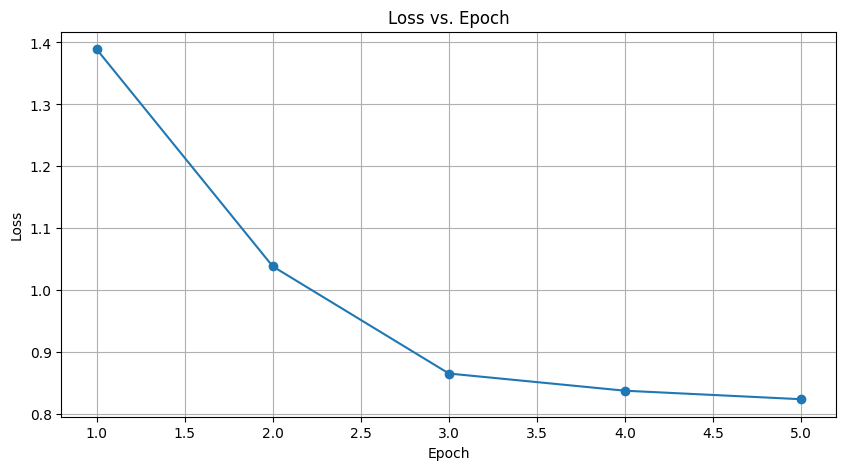

In [24]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

# Implement GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the GraphSAGE model
model = GraphSAGE(in_channels=embedding_dim, hidden_channels=64, out_channels=embedding_dim)

# Example training loop with margin-based contrastive loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 5  # Number of epochs
margin = 1.0  # Margin for contrastive loss
losses = []  # To store the loss values

# Training loop with progress bar
for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
    model.train()
    optimizer.zero_grad()

    # Forward pass: Get the embeddings from the model
    out = model(data.x, data.edge_index)

    # Assume that we have positive and negative pairs for contrastive learning
    anchor = out[edge_index[0]]  # Embedding of the current item
    positive = out[edge_index[1]]  # Embedding of the next item in sequence
    negative = out[torch.randint(0, len(unique_aids), (len(edge_index[1]),))]  # Random negative samples

    # Calculate distances for contrastive loss
    positive_distance = F.pairwise_distance(anchor, positive)
    negative_distance = F.pairwise_distance(anchor, negative)

    # Margin-based contrastive loss
    loss = torch.mean(positive_distance + torch.relu(margin - negative_distance))

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Store the loss value
    losses.append(loss.item())

    # Print the loss for this epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

# Plot the loss vs epoch graph after training is complete
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Get final embeddings
with torch.no_grad():
    embeddings = model(data.x, data.edge_index)

In [25]:
%%time

# Build Annoy index with learned embeddings
annoy_index = AnnoyIndex(embedding_dim, 'angular')

# Add embeddings to the Annoy index
for i in range(len(unique_aids)):
    annoy_index.add_item(i, embeddings[i].numpy())

# Build the index with n_trees (more trees increase accuracy)
annoy_index.build(n_trees=5)
annoy_index.save('/content/drive/MyDrive/Colab Notebooks/OTTO Recommendation System./annoy_index.ann')

CPU times: user 36.3 s, sys: 1.07 s, total: 37.3 s
Wall time: 20.1 s


True

## Validation / Inference

In [26]:
from tqdm import tqdm

# Initialize a counter for the number of hits
hits = 0

# Total number of predictions
total_predictions = len(test)

# Iterate over each row in the test dataframe with a tqdm progress bar
for row in tqdm(test.iter_rows(named=True), total=total_predictions, desc="Processing"):
    prev_aid = row['prev_aid']
    true_aid = row['aid']

    # Convert prev_aid to its corresponding index
    if prev_aid in aid_to_idx:
        prev_aid_idx = aid_to_idx[prev_aid]

        # Predict the top 10 most likely items using the Annoy index
        top_10_similar = annoy_index.get_nns_by_item(prev_aid_idx, 10)

        # Convert indices back to article IDs
        recommended_aids = [idx_to_aid[idx] for idx in top_10_similar]

        # Check if the true aid (current article ID) is in the recommended items
        if true_aid in recommended_aids:
            hits += 1

# Calculate Hit Rate
hit_rate = hits / total_predictions

# Print the Hit Rate
print(f"/n Hit Rate: {hit_rate * 100:.2f}%")


Processing: 100%|██████████| 4627313/4627313 [01:56<00:00, 39557.04it/s]

/n Hit Rate: 12.68%


In [27]:
from google.colab import runtime
runtime.unassign()